In [ ]:
''''In tis main file we do an initial explortation, we clean the data, and perfoirm EDA and vizualisation'''

import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import initial_exploration as explo
import data_cleaning as cl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)

In [ ]:
# Load datasets:
cash_requests = pd.read_csv('project_dataset/extract - cash request - data analyst.csv')
fees = pd.read_csv('project_dataset/extract - fees - data analyst - .csv')

In [ ]:
cash_requests.head()

In [ ]:
# Inital exploration:
explo.check(cash_requests)

In [ ]:
cl.convert_dates(cash_requests, cl.cash_request_date_columns)

# Re-check and ensure correct data types in cash_requests:
cl.ensure_correct_data_types(cash_requests, cl.cash_request_date_columns)

cash_requests.head()

In [ ]:
explo.check(cash_requests)

In [ ]:
fees.head()

In [ ]:
explo.check(fees)

In [ ]:
cl.convert_dates(fees, cl.fees_data_date_columns)

# Re-check and ensure correct data types in cfees:
cl.ensure_correct_data_types(fees, cl.fees_data_date_columns)

fees.head()

In [ ]:
cl.rename_col(cash_requests, 'id', 'cash_request_id')
data_df = cl.merge_df(cash_requests, fees, 'outer', 'cash_request_id')
data_df = cl.rename_col_xy(data_df)
data_df.head(20)

In [ ]:
data_df.sample(10)

In [ ]:
cl.rename_col(data_df, 'id', 'id_fee')
cl.clean_text_column(data_df, "reason")
explo.check(data_df)

In [ ]:
data_df = cl.remove_nan(data_df, "cash_request_id")
explo.check_null(data_df)

In [ ]:
data_df = cl.drop_col(data_df, ["id_fee", "category"])
data_df.head(10)

In [ ]:
explo.check_null(data_df)

In [ ]:
frames = cl.selecting_data_types(data_df)
num = frames[1]
cat = frames[0]
date = frames[2]

In [ ]:
num.head()

In [ ]:
explo.check_null(num)

In [ ]:
cat.head()

In [ ]:
explo.check_null(cat)

In [ ]:
date.head()

In [ ]:
explo.check_null(date)

In [ ]:
# Verify specific date columns' data types in cash_requests:
print("\nCheck data types of date columns:")
print(cash_requests[['created_at', 'updated_at', 'moderated_at', 'reimbursement_date', 
                     'cash_request_received_date', 'money_back_date', 'send_at', 'reco_creation', 'reco_last_update']].dtypes)

# Check for any NaT in date columns:
print("\nCheck NaT (missing values) in date columns:")
print(cash_requests[['created_at', 'updated_at', 'moderated_at', 'reimbursement_date', 
                     'cash_request_received_date', 'money_back_date', 'send_at', 'reco_creation', 'reco_last_update']].isna().sum())

In [ ]:
df_time_between_CR_and_money_back = cl.process_date_columns(date, "CR_created_at", "money_back_date")
df_time_between_CR_and_money_back.head()

In [ ]:
explo.check(df_time_between_CR_and_money_back)

In [ ]:
df_time_between_fee_created_and_paid_at_date = cl.process_date_columns(date, "fee_created_at", "paid_at")
df_time_between_fee_created_and_paid_at_date.head(20)

In [ ]:
explo.check(df_time_between_fee_created_and_paid_at_date)

In [ ]:
# We can divide the columns between us and ecah work in a set of columns performing an 
# univariate analysis (frequency plots, box plots, doughnut, histograms   or any other you concider)
#For numercial plots also create report in mean , meadian, std, and arrive to conclusions 

In [ ]:
data_df['first_advance_date'] = data_df.groupby('user_id')['CR_created_at'].transform('min')
#create cohort using dates from the first transactions, and grouping all users according to user id.

In [ ]:
data_df['cohort_month'] = data_df['first_advance_date'].dt.to_period('M')
# extracts month and year from the first advance column and converts it to a period format.

In [ ]:
data_df['cohort_index'] = (data_df['CR_created_at'].dt.year - data_df['first_advance_date'].dt.year) * 12 + \
                     (data_df['CR_created_at'].dt.month - data_df['first_advance_date'].dt.month) + 1
# finds difference in years between two dates, *12 converts into months.
print(data_df.info()) #check if the cohort column exists

In [ ]:
data_df['cohort_month'] = data_df['first_advance_date'].dt.to_period('M')
data_df.groupby('cohort_month').size()
# extracts the month and year from the list of first advance and creates a new column, 
# cohort month, that shows how many users interacted with the service.


In [ ]:
cohort_table = data_df.groupby(['cohort_month', data_df['CR_created_at'].dt.to_period('M')])['user_id'].count()
cohort_table = cohort_table.unstack()
cohort_table = cohort_table.fillna(0)
print(cohort_table)

In [ ]:
cohort_size = data_df.groupby('cohort_month')['user_id'].nunique()
# counts how many unique users belong to each cohort month. 
cohort_size


In [ ]:
# count the number of times each user used the service in each month
cohort_usage = data_df.groupby(['cohort_month', data_df['CR_created_at'].dt.to_period('M')])['user_id'].count()

# each row is a cohort, and each column is a month
cohort_usage = cohort_usage.unstack(fill_value=0)
# Calculate the frequency of service usage by dividing the usage count by cohort size
cohort_usage_frequency = cohort_usage.divide(cohort_size, axis=0)  # Divide usage by cohort size

In [ ]:
cohort_usage_percentage = cohort_usage.div(cohort_size, axis=0) * 100
cohort_usage_percentage.fillna(0, inplace=True)


In [ ]:
data_df['first_advance_date'] = data_df.groupby('user_id')['CR_created_at'].transform('min')
data_df['cohort_month'] = data_df['first_advance_date'].dt.to_period('M')

new_users = data_df.groupby('cohort_month')['user_id'].nunique()

interactions = data_df.groupby('cohort_month')['user_id'].count()

frequency_of_usage = interactions / new_users
cohort_usage_matrix = data_df.groupby(['cohort_month', data_df['CR_created_at'].dt.to_period('M')])['user_id'].count().unstack()

cohort_usage_matrix.fillna(0, inplace=True)

plt.figure(figsize=(12, 8))
sns.heatmap(cohort_usage_matrix, annot=True, fmt='g', cmap='Blues', cbar=True)
plt.title('Heatmap of Service Usage by Cohort and Month')
plt.xlabel('Month of Interaction')
plt.ylabel('Cohort Month')
plt.xticks(rotation=45) 
plt.show()


In [ ]:
frequency_by_month = cohort_table.sum(axis=0) 

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=frequency_by_month.index.astype(str), y=frequency_by_month.values, palette='Blues')

plt.title('Frequency of Service Usage by Month')
plt.xlabel('Month')
plt.ylabel('Number of Interactions')
plt.xticks(rotation=45)
plt.show()


In [ ]:
frequency_table = cohort_table.sum(axis=0) 
frequency_table = frequency_table.reset_index() 
frequency_table.columns = ['Month', 'Total Interactions']
print(frequency_table)


In [ ]:
# Define relevant incident types based on the 'reason' column:
incident_reasons = ['rejected direct debit', 'month delay on payment']

# Filter data for rows that have incidents:
incident_data = data_df[data_df['reason'].isin(incident_reasons)]

# Group by cohort month and count the number of incidents per cohort:
incident_counts = incident_data.groupby('cohort_month')['user_id'].nunique()

# Group by cohort month to count total requests:
total_requests = data_df.groupby('cohort_month')['user_id'].nunique()

# Calculate incident rate (number of incidents / total requests per cohort):
incident_rate = incident_counts / total_requests * 100

# Print incident rate by cohort:
print(incident_rate)

In [ ]:
# Frequency table with absolute counts:
frequency_table = (data_df[data_df['reason'].isin(['rejected direct debit', 'month delay on payment', 'postpone cash request'])]
                   .groupby(['cohort_month', 'reason'])
                   .size()
                   .unstack(fill_value=0))

# Add total column for each cohort month:
frequency_table['Total Incidents'] = frequency_table.sum(axis=1)

# Display table:
print(frequency_table)

In [ ]:
# Filter only relevant incidents:
incident_counts = (data_df[data_df['reason'].isin(['rejected direct debit', 'month delay on payment', 'postpone cash request'])]
                   .groupby(['cohort_month', 'reason'])
                   .size()
                   .unstack(fill_value=0))

# Plot grouped bar chart:
incident_counts.plot(kind='bar', figsize=(10, 6), width=0.8)

# Labels and formatting:
plt.title('Incident Count by Cohort Month')
plt.ylabel('Number of Incidents')
plt.xlabel('Cohort Month')
plt.xticks(rotation=45)
plt.legend(title="Incident Types", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Filter only relevant incidents:
incident_counts = (data_df[data_df['reason'].isin(['rejected direct debit', 'month delay on payment', 'postpone cash request'])]
                   .groupby(['cohort_month', 'reason'])
                   .size()
                   .unstack(fill_value=0))

# Compute total requests per cohort:
total_requests = data_df.groupby('cohort_month').size()

# Calculate incident rate as a percentage:
incident_rate = (incident_counts.div(total_requests, axis=0) * 100)

# Plot stacked bar chart:
incident_rate.plot(kind='bar', stacked=True, figsize=(10, 6))

# Labels and formatting:
plt.title('Incident Rate by Cohort Month')
plt.ylabel('Incident Rate (%)')
plt.xlabel('Cohort Month')
plt.xticks(rotation=45)
plt.legend(title="Incident Types", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

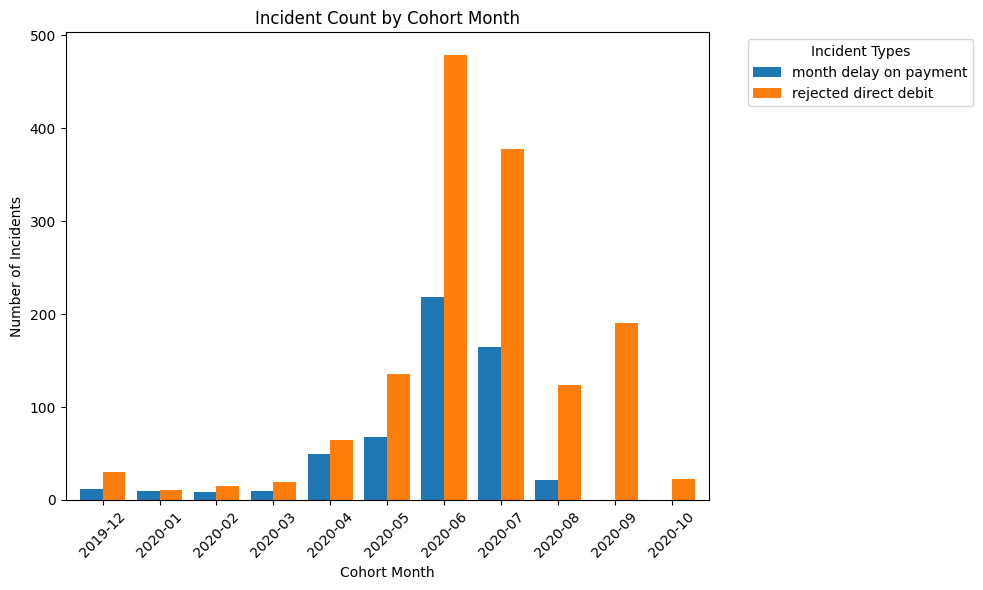

In [ ]:
import matplotlib.pyplot as plt

# Filter only relevant incidents:
incident_counts = (data_df[data_df['reason'].isin(['rejected direct debit', 'month delay on payment', 'postpone cash request'])]
                   .groupby(['cohort_month', 'reason'])
                   .size()
                   .unstack(fill_value=0))

# Plot grouped bar chart:
incident_counts.plot(kind='bar', figsize=(10, 6), width=0.8)

# Labels and formatting:
plt.title('Incident Count by Cohort Month')
plt.ylabel('Number of Incidents')
plt.xlabel('Cohort Month')
plt.xticks(rotation=45)
plt.legend(title="Incident Types", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
